In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances


The Haversine distance is used to calculate the true geographic distance between two points on the Earth's surface. Here’s why it’s important:

### **Why Calculate Haversine Distance?**

1. **Geographic Accuracy:**
   - **True Distance:** Haversine calculates the shortest path over the Earth's surface, accounting for its curvature. This is crucial for accurately measuring distances between geographical points.

2. **Clustering Relevance:**
   - **Spatial Clustering:** When clustering geographical data, using actual distances helps ensure that clusters represent true geographic proximity. This can improve the quality and relevance of the clusters.

3. **Data Integrity:**
   - **Natural Metrics:** Using Haversine distance respects the natural geometry of the Earth, unlike simple Euclidean distance, which doesn’t account for Earth's curvature and can lead to inaccuracies.

### **Example Use Case**

For clustering locations of stores or customers, Haversine distance ensures that the clustering algorithm groups data points based on real-world distances rather than arbitrary numerical values.



In [3]:

def haversine(u, v):
    lon1, lat1 = u[0], u[1]
    lon2, lat2 = v[0], v[1]
    
    # Convert degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

## 1. Numerical Features Scaling Pipeline
This pipeline will scale numerical features, including latitude and longitude.

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define the numerical features and create the scaling pipeline
numerical_features = ['Age']

numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])


## 2. Categorical Features Encoding Pipeline
This pipeline will handle encoding of categorical features.

In [32]:
!pip install category-encoders -qU

In [33]:
import category_encoders as ce
categorical_transformer = ce.BinaryEncoder(cols=categorical_features)


In [34]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define the cat egorical features and create the encoding pipeline
categorical_features = ["Ethnicity","Diabetic","Religion","Height","last_name"]

categorical_pipeline = Pipeline(steps=[
    ('encoder', ce.BinaryEncoder(cols=categorical_features))
])


## 4. Geo Pipeline
This pipeline will handle encoding/scaling latitude and longitude columns

36.9092860906283

In [51]:
# Pipeline for geographical features (latitude and longitude)

geo_features = ['latitude', 'longitude']

geo_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Scale latitude and longitude
    # ('haversine', HaversineDistanceTransformer())  # Compute Haversine distances
])


## 5. Define the column transformer to apply appropriate pipelines


In [52]:
preprocessor = ColumnTransformer(
    transformers=[
        ('geo', geo_pipeline, geo_features),
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

## 6. Apply the Preprocessor
Fit and transform the data using the preprocessor pipeline.



In [53]:
import pandas as pd

# Load the data
df = pd.read_csv("train.csv")

# Apply the preprocessor pipeline
X_transformed = preprocessor.fit_transform(df)

print(X_transformed.shape)  # Check the shape of the transformed data


(12556, 24)


In [54]:
preprocessor

ColumnTransformer(transformers=[('geo',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['latitude', 'longitude']),
                                ('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Age']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  BinaryEncoder(cols=['Ethnicity',
                                                                      'Diabetic',
                                                                      'Religion',
                                                                      'Height',
                                                                      'last_name']))]),
                                 ['Ethnicity', 'Diabetic', 'Religion', 'Height',
                                  'last_name'])])

In [55]:
test_df = pd.read_csv("test.csv")
x_test = preprocessor.transform(test_df)
print(x_test.shape)  # Check the shape of the transformed data


(1, 24)


## 7. Combine with a Clustering Model
We can then use the transformed data to fit a clustering model. Here’s how to integrate it with a clustering pipeline:

In [22]:
!pip install kneed -q

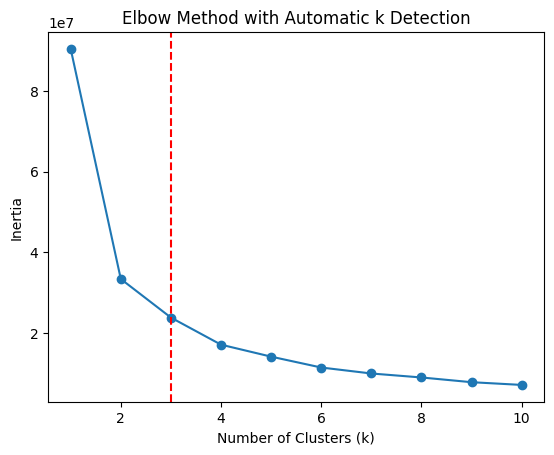

Optimal number of clusters: 3


In [21]:
import numpy as np
from kneed import KneeLocator
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs



# Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_transformed)
    inertia.append(kmeans.inertia_)

# Find the optimal k using KneeLocator
kneedle = KneeLocator(range(1, 11), inertia, curve='convex', direction='decreasing')
optimal_k = kneedle.elbow

# Plot the results
plt.plot(range(1, 11), inertia, marker='o')
plt.axvline(x=optimal_k, color='r', linestyle='--')
plt.title('Elbow Method with Automatic k Detection')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

print(f"Optimal number of clusters: {optimal_k}")


In [24]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# Define the full pipeline including clustering
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('cluster', KMeans(n_clusters=optimal_k))  # Example with 3 clusters
])

# Fit the full pipeline
full_pipeline.fit(df)

# Predict clusters
df['Cluster'] = full_pipeline.predict(df)

print(df.head())  # Check the resulting DataFrame with clusters


   Age   latitude   longitude Ethnicity Diabetic        Religion   Height  \
0   46  43.469852 -109.502869   Italian      Yes           Deism    Short   
1   41  26.040271 -115.130319  Japanese      Yes           Islam    Short   
2   27  33.345173  -72.874953  Japanese      Yes        Druidism  Average   
3   61  37.971990  -97.647942   Mexican      Yes        Paganism  Average   
4   20  28.489021  -99.225687   Mexican      Yes  Zoroastrianism  Average   

  last_name  Cluster  
0      Hill        1  
1      Hill        0  
2  Williams        0  
3    Wilson        2  
4     Allen        0  


## 8. Evaluation

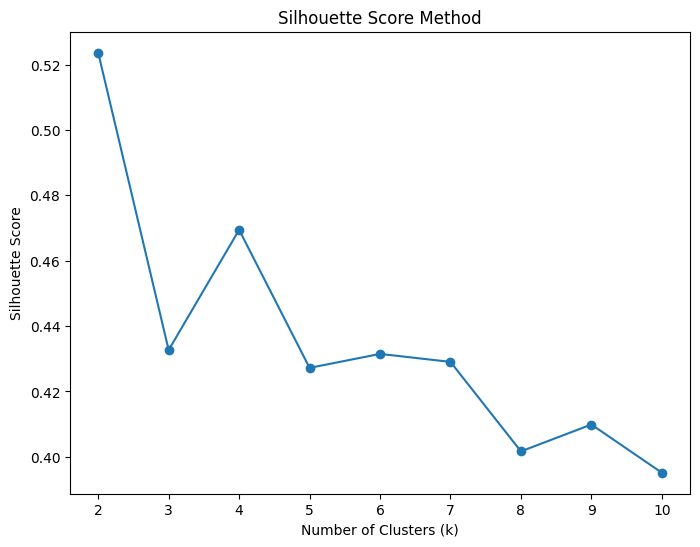

In [26]:
from sklearn.metrics import silhouette_score

sil_scores = []

# Try different values of k
for k in range(2, 11):  # silhouette score is not defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_transformed)
    labels = kmeans.labels_
    sil_score = silhouette_score(X_transformed, labels)
    sil_scores.append(sil_score)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), sil_scores, marker='o')
plt.title('Silhouette Score Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


From the Silhouette Score plot, the ideal number of clusters for k-means clustering is typically the one with the highest score, indicating the best separation between clusters. In your plot:

- The highest Silhouette Score is observed at **k = 2**, with a score of approximately 0.52.
- There is another noticeable peak at **k = 4**, but the score is lower compared to k = 2.

Since the highest score is at **k = 2**, this suggests that two clusters might be the best choice in this scenario for optimal separation and structure of the data.

----
But in the Elbow Method, the Knee Locator suggests that the optimal number of clusters is **3**. This is indicated by the red dashed line at k = 3, where there's a noticeable "elbow" or a significant change in the slope of the inertia curve.

In summary:

- The Silhouette Score method suggested **k = 2** as the best number of clusters.
- The Elbow Method (using the Knee Locator) suggests **k = 3**.

Given these conflicting suggestions, you might consider the following:

1. **Evaluate Model Performance:** Compare clustering performance for both k = 2 and k = 3 using domain-specific validation metrics or business requirements.
2. **Cluster Interpretability:** Consider which number of clusters makes more sense based on the interpretability of the clusters.
3. **Silhouette Analysis for k = 3:** Further analyze the silhouette scores specifically for k = 3 to see if it still provides acceptable separation quality.

Balancing these insights should help us determine the best k value for your use case.

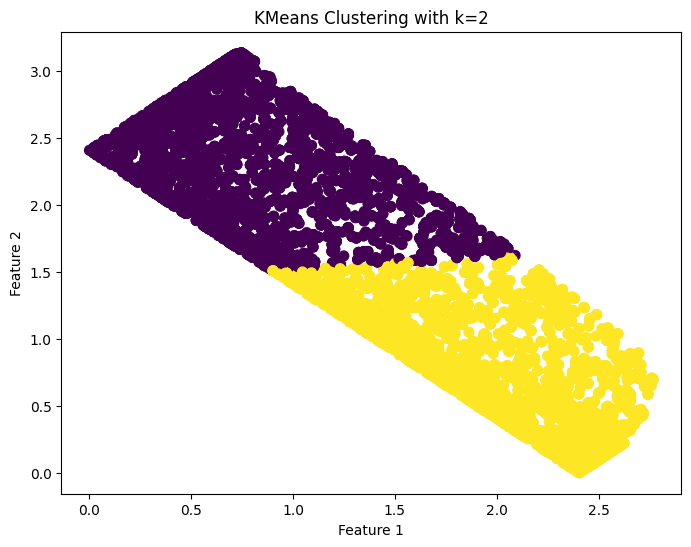

Silhouette Score for k=2: 0.5236155980296727


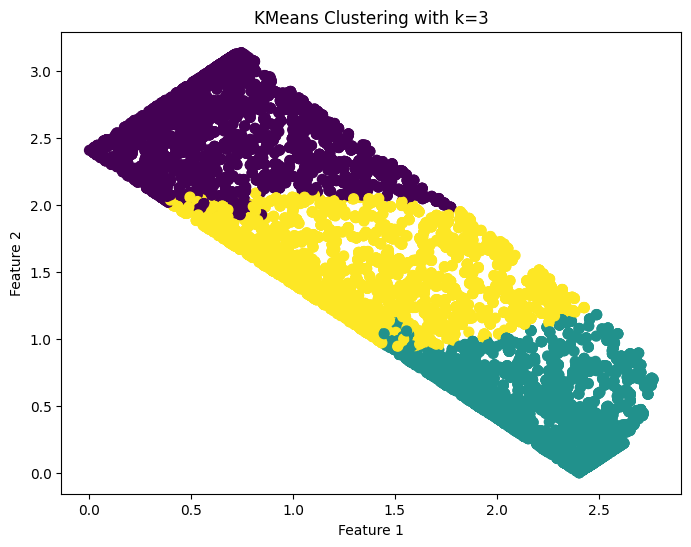

Silhouette Score for k=3: 0.43266845293604034


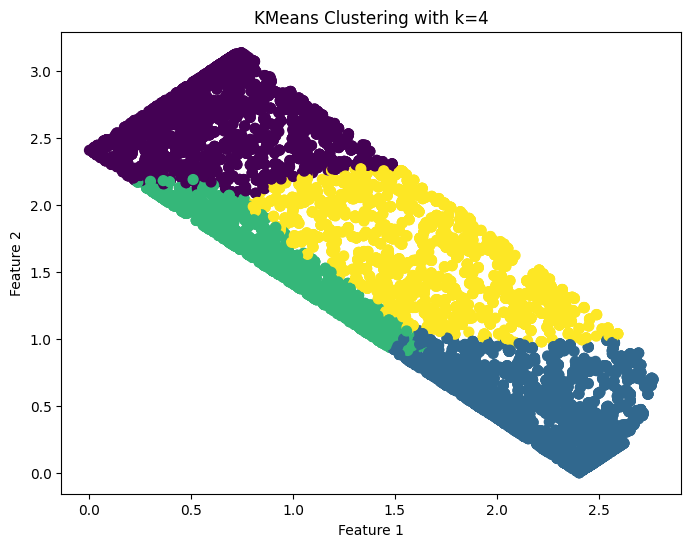

Silhouette Score for k=4: 0.4694389329632387


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs


# Evaluate k=2, k=3, and k=4
for k in [2, 3, 4]:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_transformed)
    labels = kmeans.labels_
    sil_score = silhouette_score(X_transformed, labels)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=labels, s=50, cmap='viridis')
    plt.title(f'KMeans Clustering with k={k}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()
    
    print(f'Silhouette Score for k={k}: {sil_score}')

# Compare elbow and silhouette methods


### Let’s visualize the clusters for \( k = 2 \), \( k = 3 \), and \( k = 4 \) to help decide which provides the most meaningful clustering.

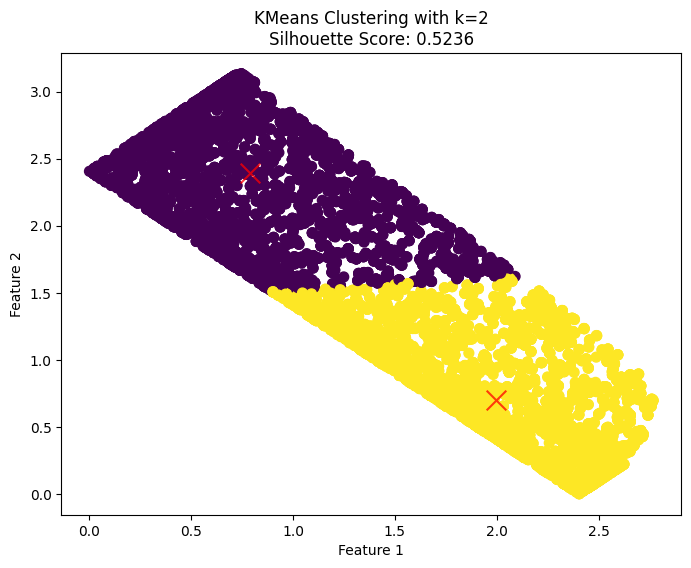

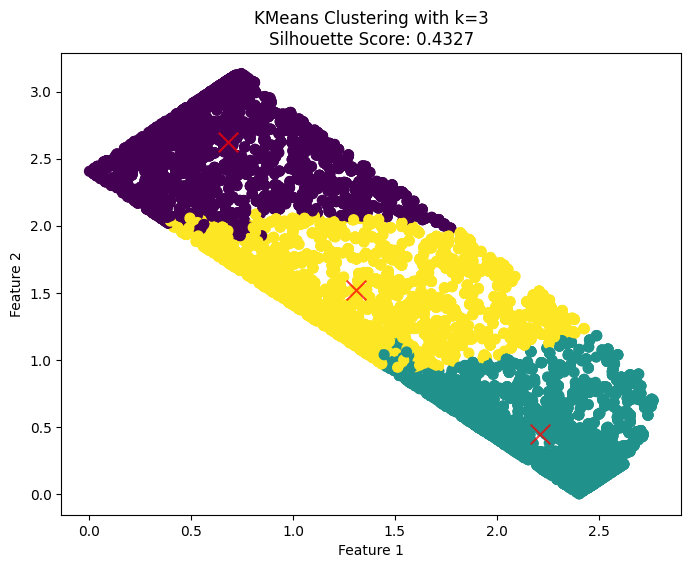

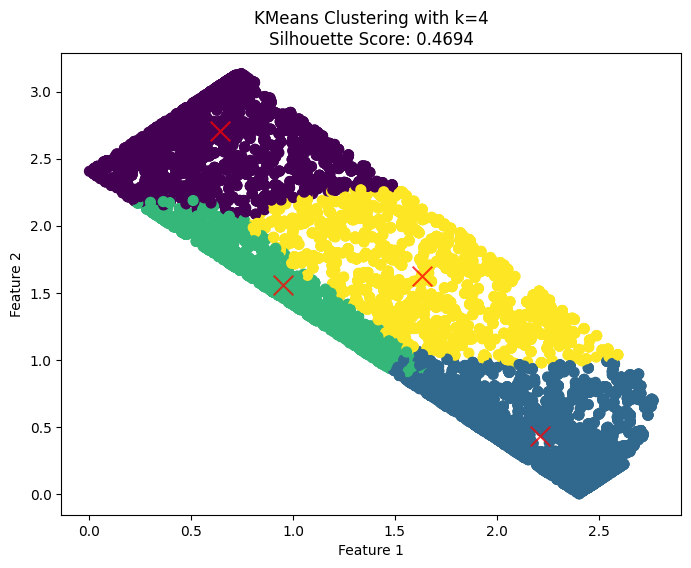

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score


# Function to plot clusters
def plot_kmeans(k, X):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    sil_score = silhouette_score(X, labels)

    # Plot the clusters
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.75, marker='x')
    plt.title(f'KMeans Clustering with k={k}\nSilhouette Score: {sil_score:.4f}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Plot clusters for k=2, k=3, and k=4
for k in [2, 3, 4]:
    plot_kmeans(k, X_transformed)





### What the Code Does:
1. **Cluster Generation**: We generate synthetic data with `make_blobs`.
2. **KMeans Model**: For each \( k \) (2, 3, and 4), we apply k-means clustering.
3. **Plot**: We visualize the clusters with different colors and mark the cluster centroids with red `x` symbols.
4. **Silhouette Score**: The Silhouette Score is calculated and displayed in the title of each plot.

### How to Interpret:
- **Shape and Separation of Clusters**: Look at how well-separated the clusters are and whether adding more clusters (e.g., \( k = 4 \)) introduces useful distinctions or unnecessary complexity.
- **Centroid Placement**: Centroids (red `x`) help indicate the center of each cluster.
- **Visual Distinction**: Observe if increasing \( k \) results in a clearer separation of different groups.

Run the code and examine the plots. Based on these visuals and the silhouette scores, you can make an informed decision on whether \( k = 2 \), \( k = 3 \), or \( k = 4 \) is more appropriate for your data.


## Report

Given our goal of returning nearby matches based on multiple features like latitude, longitude, surname, and other attributes, **\( k = 4 \)** might be the best option. Here's why:

1. **Granularity**: With \( k = 4 \), the clusters provide more granularity, which could help you identify more localized or fine-tuned groups based on geography (latitude/longitude) and surname.
   
2. **Balance**: Though \( k = 2 \) has the highest silhouette score, it seems too broad, and having just two clusters may not effectively capture diverse subgroups in your data. \( k = 3 \) doesn't separate well, as seen from the plots. 

3. **Features**: Since we're clustering based on multiple attributes, having more clusters (like 4) can improve the likelihood of finding better matches across multiple features, like geographic proximity and surname similarity.

By choosing \( k = 4 \), we can better reflect the nuances in our data and improve the likelihood of returning more accurate, feature-aligned matches.

In [58]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# Define the full pipeline including clustering
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('cluster', KMeans(n_clusters=4))  
])

# Fit the full pipeline
full_pipeline.fit(df)

# Predict clusters
df['Cluster'] = full_pipeline.predict(df)

# Check the resulting DataFrame with clusters
df.head()

,Age,latitude,longitude,Ethnicity,Diabetic,Religion,Height,last_name,Cluster
0,46,43.469852,-109.502869,Italian,Yes,Deism,Short,Hill,2
1,41,26.040271,-115.130319,Japanese,Yes,Islam,Short,Hill,1
2,27,33.345173,-72.874953,Japanese,Yes,Druidism,Average,Williams,3
3,61,37.971990,-97.647942,Mexican,Yes,Paganism,Average,Wilson,0
4,20,28.489021,-99.225687,Mexican,Yes,Zoroastrianism,Average,Allen,3


In [57]:
import joblib
import pandas as pd

# Save the preprocessor
joblib.dump(preprocessor, 'preprocessor_pipeline.pkl')

# Save the KMeans model
# joblib.dump(kmeans, 'kmeans_model.pkl')

# Save the entire pipeline
joblib.dump(full_pipeline, 'full_pipeline.pkl')

# Save the transformed data
import numpy as np

# Save the transformed data as an NPZ file
np.savez('X_transformed.npz', X_transformed=X_transformed)

# Save the original data
df.to_csv('df_cluster.csv', index=False)
